In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, BooleanType
from pyspark.sql.functions import count, col, when
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

### Create functions

In [2]:
def load_and_join_csv_files(schema, start_range, stop_range, file_name):
    # create a SparkSession
    spark = SparkSession.builder.appName("appName").getOrCreate()

    # load CSV files into Spark DataFrames
    dfs = []
    for i in range(start_range, stop_range):
        file_path = file_name.format(i)
        df = spark.read.csv(file_path, header=False, inferSchema=False, schema=schema)
        dfs.append(df)

    # join all DataFrames
    union_df = dfs[0]
    for df in dfs[1:]:
        union_df = union_df.unionAll(df)

    return union_df

In [3]:
def drop_duplicate_rows(df, cols_for_drop_duplicate_rows):
    return df.dropDuplicates(subset=cols_for_drop_duplicate_rows)

In [4]:
def drop_columns(df, cols_to_drop):
    for col_name in cols_to_drop:
        df = df.drop(col(col_name))
    return df

In [5]:
def print_rows_dropped(df_before, df_after):
    num_rows_before = df_before.count()
    num_rows_after = df_after.count()
    num_duplicates_dropped = num_rows_before - num_rows_after

    print(f"Number of rows before: {num_rows_before}")
    print(f"Number of rows after: {num_rows_after}")
    print(f"Number of duplicate rows dropped: {num_duplicates_dropped}")

In [6]:
def print_missing_values(df):
    missing_values = df.agg(*[
        count(when(col(c).isNull(), c)).alias(c) for c in df.columns
    ])
    print("Missing values:")
    missing_values.show()

In [7]:
def print_summary_stats(df, num_cols):
    summary_stats = df.select(num_cols).describe()
    print("Summary statistics of numerical columns:")
    summary_stats.show()

### Apply functions

In [8]:
# define parameters for creating df
schema_csv = StructType([
  StructField("Unnamed: 0", IntegerType(), True),
  StructField("tconst", StringType(), True),
  StructField("primaryTitle", StringType(), True),
  StructField("originalTitle", StringType(), True),
  StructField("startYear", IntegerType(), True),
  StructField("endYear", IntegerType(), True),
  StructField("runtimeMinutes", IntegerType(), True),
  StructField("numVotes", DoubleType(), True),
  StructField("label", BooleanType(), True)
])
start_range = 1
stop_range = 9
file_name = 'train-{}.csv'

# read and join data
union_df = load_and_join_csv_files(schema_csv, start_range, stop_range, file_name)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/10 00:06:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [9]:
# specify parameters for dropping rows/columns
list_cols_to_drop = ["Unnamed: 0"]
list_cols_to_drop_duplicate_rows = ["primaryTitle"]

# transform data
no_duplicates_df = drop_duplicate_rows(union_df, list_cols_to_drop_duplicate_rows)
df = drop_columns(no_duplicates_df, list_cols_to_drop)

### Inspect data

In [10]:
df.show()

+----------+--------------------+--------------------+---------+-------+--------------+--------+-----+
|    tconst|        primaryTitle|       originalTitle|startYear|endYear|runtimeMinutes|numVotes|label|
+----------+--------------------+--------------------+---------+-------+--------------+--------+-----+
| tt3819668|"Drágớn Báll Z: R...|Dragon Ball Z: Do...|     2015|   null|            93| 21658.0| true|
|tt10534500|               #Home|                null|     null|   2021|           158| 10591.0| true|
| tt0090556|      'night, Mớthér|      'night, Mother|     1986|   null|            96|  2244.0| true|
| tt0349047|(T)Raumschiff Sur...|                null|     2004|   null|            87| 15303.0|false|
| tt2395385|                  +1|                  +1|     2013|   null|            96|  8065.0|false|
| tt0473567|           ...Yahaan|           ...Yahaan|     2005|   null|           142|    null| true|
| tt0381838|              ...ing|              ...ing|     2003|   null| 

In [11]:
print_rows_dropped(union_df, df)

Number of rows before: 7967
Number of rows after: 7847
Number of duplicate rows dropped: 120


In [12]:
print_missing_values(df)

Missing values:
+------+------------+-------------+---------+-------+--------------+--------+-----+
|tconst|primaryTitle|originalTitle|startYear|endYear|runtimeMinutes|numVotes|label|
+------+------------+-------------+---------+-------+--------------+--------+-----+
|     0|           0|         3932|      778|   7070|            14|     779|    1|
+------+------------+-------------+---------+-------+--------------+--------+-----+



In [13]:
num_cols = ['startYear', 'endYear', 'runtimeMinutes', 'numVotes']
print_summary_stats(df, num_cols)

Summary statistics of numerical columns:
+-------+------------------+------------------+------------------+------------------+
|summary|         startYear|           endYear|    runtimeMinutes|          numVotes|
+-------+------------------+------------------+------------------+------------------+
|  count|              7069|               777|              7833|              7068|
|   mean| 1998.005234120809|1998.8262548262549|105.69436997319035| 29361.30249009621|
| stddev|21.962058933278172|  21.9592389616577|25.459511211894753|114675.03148723926|
|    min|              1918|              1921|                45|            1001.0|
|    max|              2021|              2021|               551|         2503641.0|
+-------+------------------+------------------+------------------+------------------+



### Distributions with NumPy

In [14]:
def plot_histogram(df, column_name, max_value, num_bins):
    # remove outliers and null values from the specified column
    cleaned_df = df.filter((col(column_name).isNotNull()) & (col(column_name) < max_value)).fillna(0, subset=[column_name]).select(column_name).rdd.flatMap(lambda x: x)

    # calculate histogram data
    hist, bins = np.histogram(cleaned_df.collect(), bins=num_bins)

    # plot histogram
    plt.hist(cleaned_df.collect(), bins=bins)
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column_name}')
    plt.show()

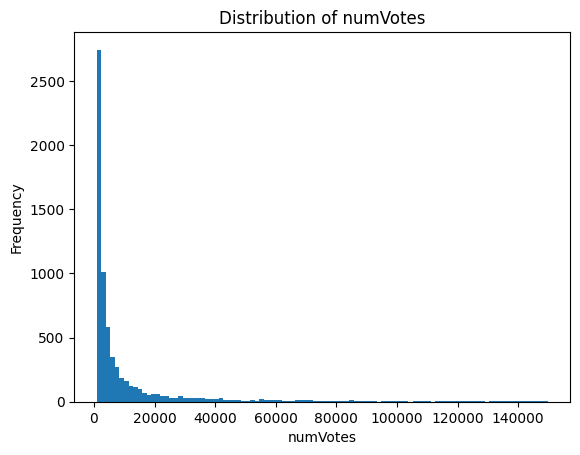

In [15]:
plot_histogram(df, 'numVotes', 150000, 100)

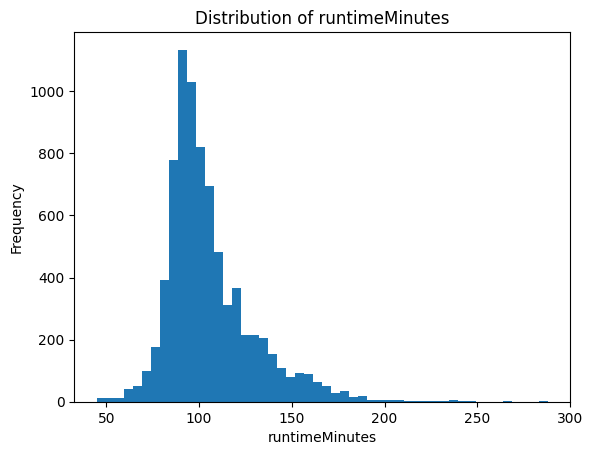

In [16]:
plot_histogram(df, 'runtimeMinutes', 300, 50)

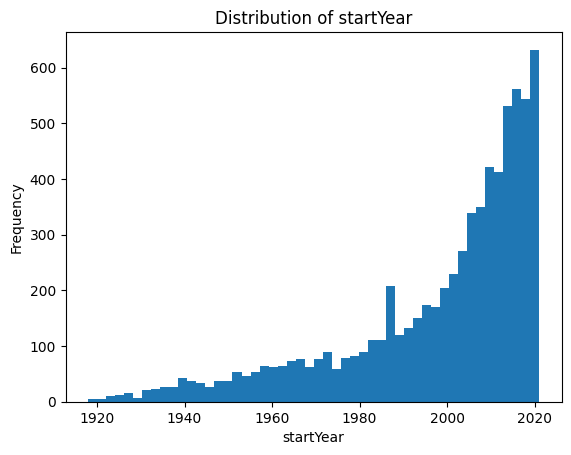

In [17]:
plot_histogram(df, 'startYear', 2025, 50)

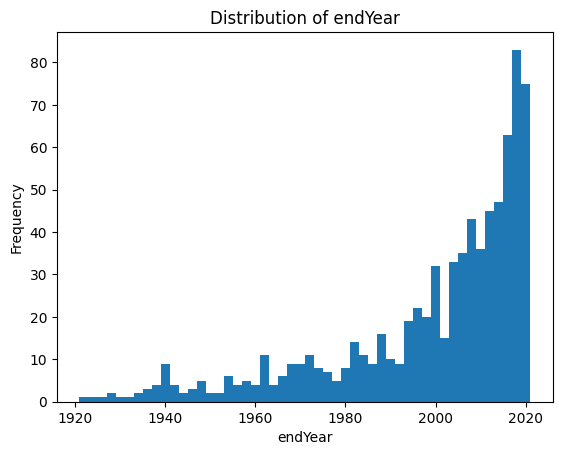

In [18]:
plot_histogram(df, 'endYear', 2025, 50)

### Correlations with Pandas

In [19]:
# converting pyspark to pandas without this function leads to deprecation error

def convert_boolean_to_integer(df, boolean_column_name):
    # convert the Boolean column to an integer column
    df = df.withColumn(boolean_column_name, when((df[boolean_column_name] == "true") | (df[boolean_column_name] == "yes"), 1).otherwise(0))

    # convert the PySpark DataFrame to a Pandas DataFrame
    df_pd = df.toPandas()

    # convert the integer column back to the original Boolean values
    df_pd[boolean_column_name] = df_pd[boolean_column_name].replace({1: True, 0: False})

    return df_pd

In [20]:
def plot_scatter(df_pd, x_column, y_column, color_column, x_label, y_label, title):
    p = ggplot(df_pd, aes(x=x_column, y=y_column, color=color_column)) + \
        geom_point() + \
        xlab(x_label) + \
        ylab(y_label) + \
        ggtitle(title)

    print(p)

In [21]:
df_pd = convert_boolean_to_integer(df, 'label')

/Users/xandersnelder/opt/anaconda3/envs/mypython3/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 1473 rows containing missing values.


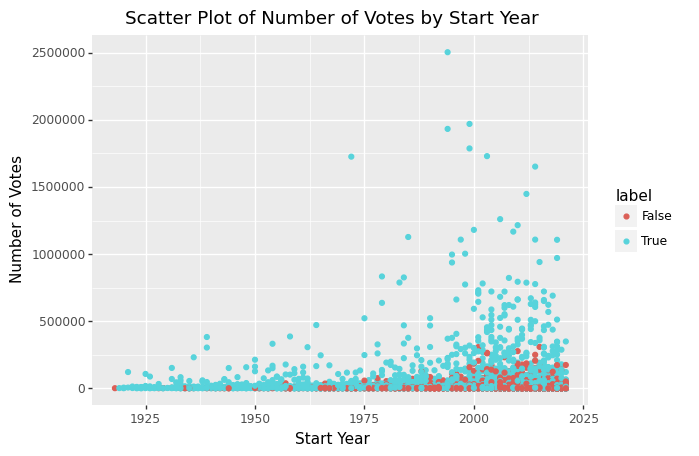

In [22]:
x_column = 'startYear'
y_column = 'numVotes'
color_column = 'label'
x_label = 'Start Year'
y_label = 'Number of Votes'
title = 'Scatter Plot of Number of Votes by Start Year'

plot_scatter(df_pd, x_column, y_column, color_column, x_label, y_label, title)

/Users/xandersnelder/opt/anaconda3/envs/mypython3/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 791 rows containing missing values.


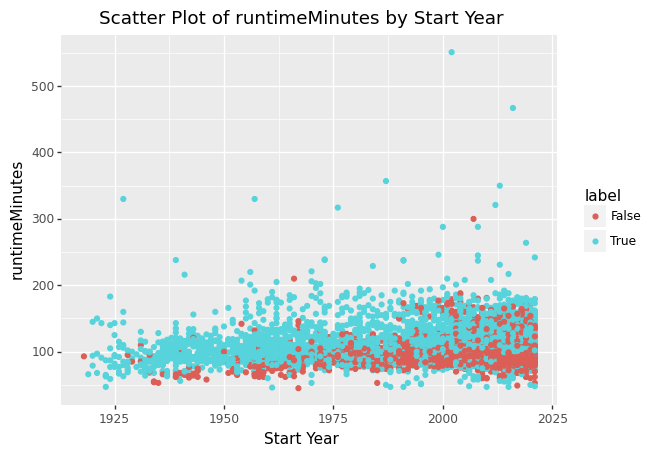

In [23]:
x_column = 'startYear'
y_column = 'runtimeMinutes'
color_column = 'label'
x_label = 'Start Year'
y_label = 'runtimeMinutes'
title = 'Scatter Plot of runtimeMinutes by Start Year'

plot_scatter(df_pd, x_column, y_column, color_column, x_label, y_label, title)

/Users/xandersnelder/opt/anaconda3/envs/mypython3/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 7153 rows containing missing values.


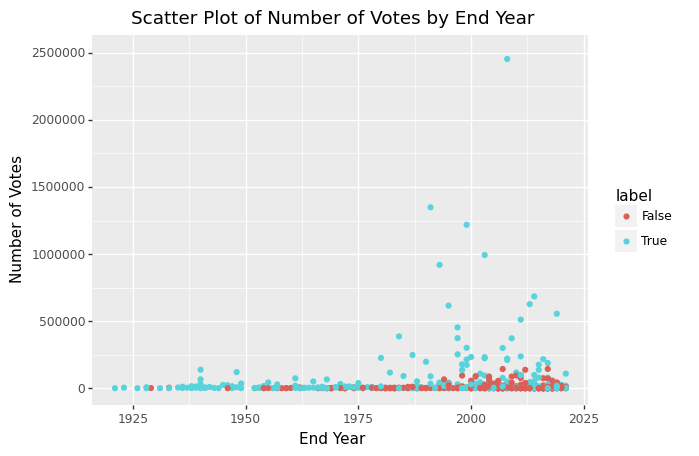

In [24]:
x_column = 'endYear'
y_column = 'numVotes'
color_column = 'label'
x_label = 'End Year'
y_label = 'Number of Votes'
title = 'Scatter Plot of Number of Votes by End Year'

plot_scatter(df_pd, x_column, y_column, color_column, x_label, y_label, title)

/Users/xandersnelder/opt/anaconda3/envs/mypython3/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_point : Removed 7070 rows containing missing values.


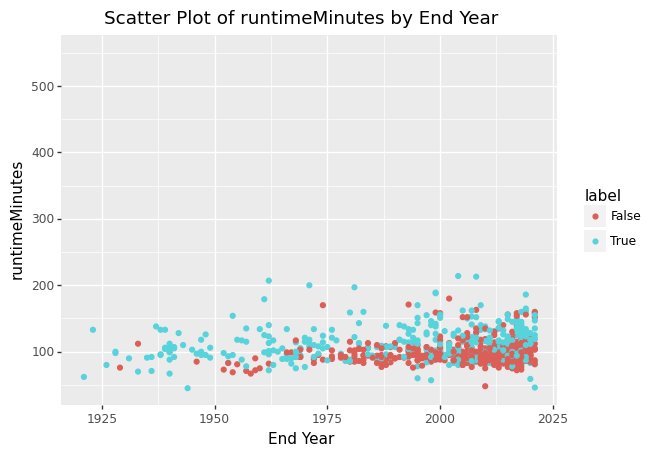

In [25]:
x_column = 'endYear'
y_column = 'runtimeMinutes'
color_column = 'label'
x_label = 'End Year'
y_label = 'runtimeMinutes'
title = 'Scatter Plot of runtimeMinutes by End Year'

plot_scatter(df_pd, x_column, y_column, color_column, x_label, y_label, title)